Hypothèse: L'algorithme va naturellement créer différents groupes:

Groupe 1 (L'élite urbaine) : Hauts revenus + Forte densité + Forte pollution (Centre de Paris).

Groupe 2 (L'injustice environnementale) : Bas revenus + Proximité route + Forte pollution.

Groupe 3 (Le confort périurbain) : Revenus moyens/hauts + Faible densité + Faible pollution.

Groupe 4 (La périphérie isolée) : Bas revenus + Faible pollution (zones rurales/éloignées).

In [3]:
import requests
from zipfile import ZipFile
import os
import py7zr
import pandas as pd
import geopandas as gpd


# importation dd dataset sur le niveau de vie et le niveau de pollution par carreaux en
# Ile de France (données Airparif et Insee)

def telecharger_donnees():
    print("téléchargement des données (environ 2 minutes)")
    dossier_projet = os.path.dirname(os.getcwd()) 
    dossier_data = os.path.join(dossier_projet, "data_carreaux")    # téléchargement des données carroyées de niveau de vie Insee
    URL_INSEE_ZIP = "https://www.insee.fr/fr/statistiques/fichier/7655475/Filosofi2019_carreaux_200m_shp.zip"
    intermediaire_zip = "donnees.zip"
    reponse = requests.get(URL_INSEE_ZIP)
    if reponse.status_code == 200:
        print("téléchargement réussi -> décompression")
        with open(intermediaire_zip, "wb") as f:
            f.write(reponse.content)
        with ZipFile(intermediaire_zip, 'r') as zip_ref:
            zip_ref.extractall(dossier_data)
        chemin_fichier_7z = os.path.join(dossier_data, "Filosofi2019_carreaux_200m_shp.7z")
        print("decompression zip terminée -> deuxième décompression")
        with py7zr.SevenZipFile(chemin_fichier_7z, mode="r") as z:
            z.extractall(path=dossier_data)

        # suppression des deux fichiers zip:
        os.remove(os.path.join(os.getcwd(), intermediaire_zip))
        os.remove(chemin_fichier_7z)
    else:
        print(f"echec du télechargement code status : {reponse.status_code}")

    # suppression des fichiers inutiles de la réunion et de la martinique
    extensions = ["dbf", "prj", "shp", "shx"]
    for e in extensions:
        try:
            os.remove(os.path.join(dossier_data, f"carreaux_200m_mart.{e}"))
        except Exception:
            print("erreur_suppresion_martinique")
        try:
            os.remove(os.path.join(dossier_data, f"carreaux_200m_reun.{e}"))
        except Exception:
            print("erreur_suppresion_reunion")

    # conversion en dataframe centré sur l'idf
    df = gpd.read_file(os.path.join(dossier_data, "carreaux_200m_met.shp"))

    # récupération des départements associés à lcog_geo
    url_base = "https://geo.api.gouv.fr/communes"
    parametres = {
        "codeRegion": "11",              # Île-de-France
        "type": "commune-actuelle,arrondissement-municipal",
        "fields": "nom,code,codeDepartement",  # Les colonnes voulues
        "format": "json"}
    response = requests.get(url_base, params=parametres)
    df2 = pd.DataFrame(response.json())

    # --- rightjoin ---
    df3 = pd.merge(df, df2, left_on="lcog_geo", right_on="code", how="right")
    df3.head()

    # --- récupération des données de pollution ---
    polluants = ["no2", "pm10", "pm25"]
    for p in polluants:
        df3[p] = pd.read_csv(os.path.join(dossier_data, f"donnees_pollution{p}_checkpoint.csv"))

    # --- suppression des données téléchargées ---
    for e in extensions:
        try:
            os.remove(os.path.join(dossier_data, f"carreaux_200m_met.{e}"))
        except Exception:
            print("erreur_suppresion_métropole")
    return (df3)

In [4]:
df=telecharger_donnees()
print(df.columns)

téléchargement des données (environ 2 minutes)
téléchargement réussi -> décompression
decompression zip terminée -> deuxième décompression
Index(['idcar_200m', 'idcar_1km', 'idcar_nat', 'i_est_200', 'i_est_1km',
       'lcog_geo', 'ind', 'men', 'men_pauv', 'men_1ind', 'men_5ind',
       'men_prop', 'men_fmp', 'ind_snv', 'men_surf', 'men_coll', 'men_mais',
       'log_av45', 'log_45_70', 'log_70_90', 'log_ap90', 'log_inc', 'log_soc',
       'ind_0_3', 'ind_4_5', 'ind_6_10', 'ind_11_17', 'ind_18_24', 'ind_25_39',
       'ind_40_54', 'ind_55_64', 'ind_65_79', 'ind_80p', 'ind_inc', 'geometry',
       'nom', 'code', 'codeDepartement', 'no2', 'pm10', 'pm25'],
      dtype='object')


In [5]:
import osmnx as ox

def recuperer_routes_idf():
    print("Récupération des routes en cours")
    
    # on récupère tous les types de routes jusqu'aux départementales
    # primary Grandes Départementales ou axes urbains majeurs
    # secondary	Routes Départementales classiques (relient les villes moyennes)
    mes_axes = ["motorway", "trunk", "primary", "secondary"]
    
    # On télécharge les axes routiers spécifiquement pour l'Île-de-France
    routes_idf = ox.features_from_place("Île-de-France, France", tags={"highway": mes_axes})
    
    # On ne garde que les géométries de type Ligne (LineString) pour éviter les erreurs
    routes_idf = routes_idf[routes_idf.geometry.type.isin(['LineString', 'MultiLineString'])]
    
    print(f"Terminé ! {len(routes_idf)} segments de routes récupérés.")
    return routes_idf

# Utilisation
base_routes = recuperer_routes_idf()

Récupération des routes en cours
Terminé ! 61599 segments de routes récupérés.


In [7]:
df=df.to_crs(epsg=2154)
base_routes=base_routes.to_crs(epsg=2154)

In [8]:
union_routes = base_routes.unary_union
df['dist_route'] = df.geometry.centroid.distance(union_routes)

C:\Users\quent\AppData\Local\Temp\ipykernel_27212\3297415445.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_routes = base_routes.unary_union


In [ ]:
import numpy as np

cols_base = [
    'idcar_200m', 'nom', 'code', 'geometry', # Identifiants et Géo
    'no2', 'pm10', 'pm25',                   # Pollution (Cibles)
    'dist_route',                            # distance avec un axe routier
    'ind_snv', 'ind', 'men', 'men_pauv',     # Richesse et Population
    'log_soc', 'men_coll',                   # Type d'habitat
]

# On crée le nouveau dataframe en filtrant
df_ml = df[[c for c in cols_base if c in df.columns]].copy()

# Feature Engineering : Création des indicateurs
df_ml['taux_pauvrete'] = (df_ml['men_pauv'] / df_ml['men']) * 100
df_ml['pct_collectif'] = (df_ml['men_coll'] / df_ml['men']) * 100

# On calcule l'écart de revenu du carreau par rapport à la moyenne de sa ville
df_ml['niveau_de_vie_unitaire'] = df_ml['ind_snv'] / df_ml['ind']

# Calcul de la médiane de ce niveau de vie pour chaque ville
df_ml['ville_niveau_vie_median'] = df_ml.groupby('nom')['niveau_de_vie_unitaire'].transform('median')

# Calculer l'écart relatif (en %) pour voir la ségrégation
df_ml['ecart_segregation_pct'] = (df_ml['niveau_de_vie_unitaire'] - df_ml['ville_niveau_vie_median']) / df_ml['ville_niveau_vie_median'] * 100

#Nettoyage final des valeurs manquantes ou infinies
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
df_ml = df_ml.dropna(subset=['no2', 'ind_snv', 'dist_route']) # On enlève les lignes inexploitables
df_ml = df_ml.fillna(0) # Le reste (ex: 0 logement social) devient 0


df_ml.head()

,idcar_200m,nom,code,geometry,no2,pm10,pm25,dist_route,ind_snv,ind,men,men_pauv,log_soc,men_coll,taux_pauvrete,pct_logement_social,pct_collectif,niveau_de_vie_unitaire,ville_niveau_vie_median,ecart_segregation_pct
1,CRS3035RES200mN2830600E3770400,Achères-la-Forêt,77001,"POLYGON ((667533.681 6804377.086, 667515.15 68...",7.457788,14.43,7.88,1992.718983,286113.8,8.5,3.4,0.3,0.0,0.0,8.823529,0.0,0.0,33660.447059,29209.18,15.239274
2,CRS3035RES200mN2830800E3770400,Achères-la-Forêt,77001,"POLYGON ((667515.15 6804576.027, 667496.618 68...",7.480239,14.42,7.87,1962.257373,1062195.9,38.0,16.0,0.0,0.0,0.0,0.000000,0.0,0.0,27952.523684,29209.18,-4.302265
3,CRS3035RES200mN2830800E3770600,Achères-la-Forêt,77001,"POLYGON ((667714.265 6804595.052, 667695.734 6...",7.492401,14.42,7.87,1764.513171,538567.1,16.0,6.4,0.6,0.0,0.0,9.375000,0.0,0.0,33660.443750,29209.18,15.239263
4,CRS3035RES200mN2831000E3770600,Achères-la-Forêt,77001,"POLYGON ((667695.734 6804793.994, 667677.203 6...",7.504329,14.41,7.86,1733.699854,1157335.3,39.0,17.0,1.0,0.0,0.0,5.882353,0.0,0.0,29675.264103,29209.18,1.595677
5,CRS3035RES200mN2831000E3770800,Achères-la-Forêt,77001,"POLYGON ((667894.85 6804813.018, 667876.319 68...",7.520233,14.40,7.86,1535.965350,965528.1,32.0,12.0,1.0,0.0,0.0,8.333333,0.0,0.0,30172.753125,29209.18,3.298871


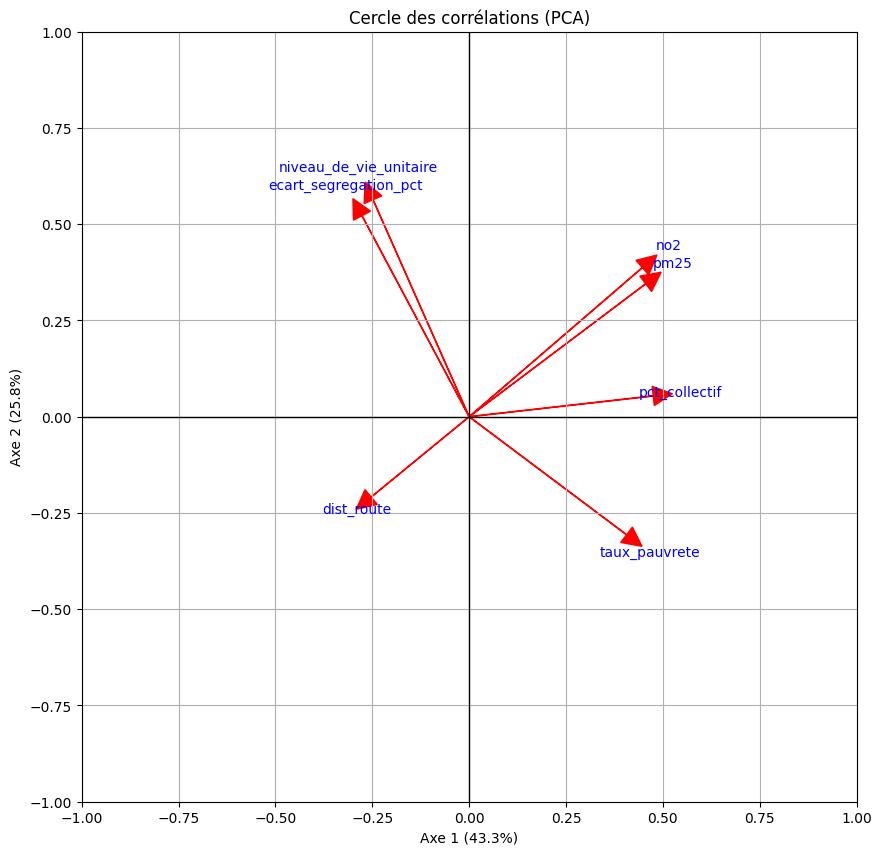

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sélection des variables pour le Machine Learning
features_ml = [
    'no2', 'pm25', 'dist_route', 'taux_pauvrete', 'niveau_de_vie_unitaire',
    'pct_collectif', 'ecart_segregation_pct'
]

X = df_ml[features_ml]

# Standardisation 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcul de l'ACP
pca = PCA(n_components=2) # On garde les 2 axes principaux pour visualiser
X_pca = pca.fit_transform(X_scaled)

# Affichage du Cercle des Corrélations
plt.figure(figsize=(10, 10))
for i, feature in enumerate(features_ml):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
              head_width=0.05, head_length=0.05, color='red')
    plt.text(pca.components_[0, i]*1.15, pca.components_[1, i]*1.15, 
             feature, color='blue', ha='center', va='center')

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.title("Cercle des corrélations (PCA)")
plt.xlabel(f"Axe 1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"Axe 2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.grid()
plt.show()

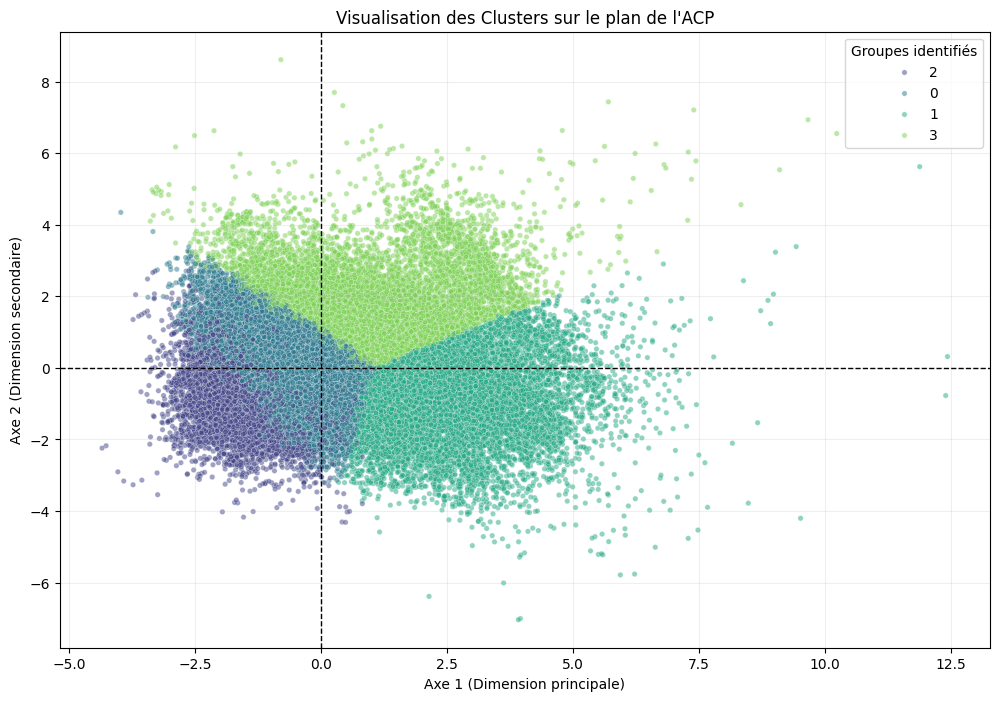

In [22]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# On calcule les clusters 
# On utilise 4 clusters pour tenter d'identifier nos 4 groupes
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_ml['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 8))

# On affiche les points (carreaux)
# x = Axe 1 de l'ACP, y = Axe 2 de l'ACP
scatter = sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=df_ml['cluster'].astype(str),
    palette='viridis',
    alpha=0.5,
    s=15
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.title("Visualisation des Clusters sur le plan de l'ACP")
plt.xlabel("Axe 1 (Dimension principale)")
plt.ylabel("Axe 2 (Dimension secondaire)")
plt.legend(title="Groupes identifiés")
plt.grid(alpha=0.2)

plt.show()

In [23]:
# liste toutes les variables qu'on veut analyser
# On inclut les variables de pollution, de richesse et les taux créés
vars_analyse = [
    'no2', 'pm25', 'dist_route', 
    'niveau_de_vie_unitaire', 'taux_pauvrete', 
    'pct_collectif',
    'ecart_segregation_pct', 'ind' 
]

# Calcul des moyennes par cluster
table_profils = df_ml.groupby('cluster')[vars_analyse].mean().round(2)

# On ajoute le nombre de carreaux par cluster (pour voir la taille des groupes)
table_profils['nb_carreaux'] = df_ml.groupby('cluster').size()

print("--- PORTRAITS-ROBOTS DES 4 CLUSTERS ---")
display(table_profils)

--- PORTRAITS-ROBOTS DES 4 CLUSTERS ---


,no2,pm25,dist_route,niveau_de_vie_unitaire,taux_pauvrete,pct_collectif,ecart_segregation_pct,ind,nb_carreaux
cluster,,,,,,,,,
0,12.22,8.68,382.39,29383.25,5.52,8.49,1.72,57.26,32111
1,23.40,10.36,247.79,21169.43,20.50,73.41,-17.36,417.73,10573
2,8.70,8.49,1871.34,28674.91,6.26,4.42,0.90,27.01,7309
3,26.78,10.84,247.26,34098.60,7.31,48.84,10.02,339.86,10090


**Cluster 0 : La Banlieue Résidentielle Aisée**
C'est le profil du confort de la "seconde couronne".
* Portrait Social : Revenus élevés (29 383 €) et très peu de pauvreté (5,52 %). 
* Exposition : L'air est nettement plus respirable ($NO_2$ à 12,22), car la distance aux routes augmente (382 m).
* Urbanisme : Très faible densité (57 individus) et habitat presque exclusivement pavillonnaire (seulement 8,49 % de collectif).
* Interprétation : Les zones résidentielles calmes. C'est le choix de l'éloignement pour protéger la qualité de vie tout en restant dans un milieu social privilégié.

**Cluster 1 : La "Double Peine" Environnementale et Sociale** 
C'est le profil le plus critique pour démontrer l'injustice environnementale.
* Portrait Social : C'est le groupe le plus précaire avec le revenu moyen le plus bas (21 169 €) et un taux de pauvreté record (20,50 %). L'écart de ségrégation est de -17,36 % ce qui signifie que ces habitants sont nettement plus pauvres que la moyenne de la ville où ils résident. Ils occupent les "moins bons" quartiers de leurs communes.
* Exposition : Ils subissent une forte pollution ($NO_2$ à 23,40) et vivent très près des axes routiers (247 m).
* Urbanisme : C'est le cluster le plus dense de ton étude (417 individus par carreau) et le plus marqué par l'habitat collectif (73,4 %).
* Interprétation : Typique des quartiers populaires de petite couronne (ex: Seine-Saint-Denis) coincés entre les infrastructures de transport.

**Cluster 2 : Le "Poumon Vert" (Zones Rurales)** 
L'espace de retrait où la voiture ne domine plus le paysage immédiat.
* Portrait Social : Niveau de vie correct (28 674 €), proche de la moyenne régionale, et très peu de pauvreté (6,26 %).Exposition : C'est le "zéro pollution" relatif ($NO_2$ à 8,70).Le Chiffre Clé : La distance aux axes routiers est immense (1 871 m). On est enfin loin du bitume. 
Urbanisme : Quasi-absence d'individus par carreau (27 individus) et d'habitat collectif (4 %).
Interprétation : Franges rurales de l'Île-de-France ou zones forestières. C'est le seul groupe réellement protégé de la pollution atmosphérique liée au trafic.

**Cluster 3 : L'Hyper-Centre Riche et Pollué**
Ce groupe montre que la pollution n'est pas qu'une affaire de pauvreté, mais aussi de centralité.
* Portrait Social : C'est le groupe le plus riche (34 098 €), avec un taux de pauvreté très faible (7,31 %).
* Exposition : Paradoxalement, c'est le cluster le plus pollué ($NO_2$ à 26,78). Il est situé à la même distance des routes que le Cluster 1 (247 m). 
* Urbanisme : Densité forte (339 individus), mais avec un mix habitat (collectif à 48,8 %).
* Interprétation : C'est l'élite urbaine (Paris Ouest, Boulogne, Levallois). Ici, la pollution est une "contrepartie" acceptée pour vivre au cœur de l'activité économique et des services.

C:\Users\quent\AppData\Local\Temp\ipykernel_27212\4201061671.py:24: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  df_ml.plot(column='nom_cluster',


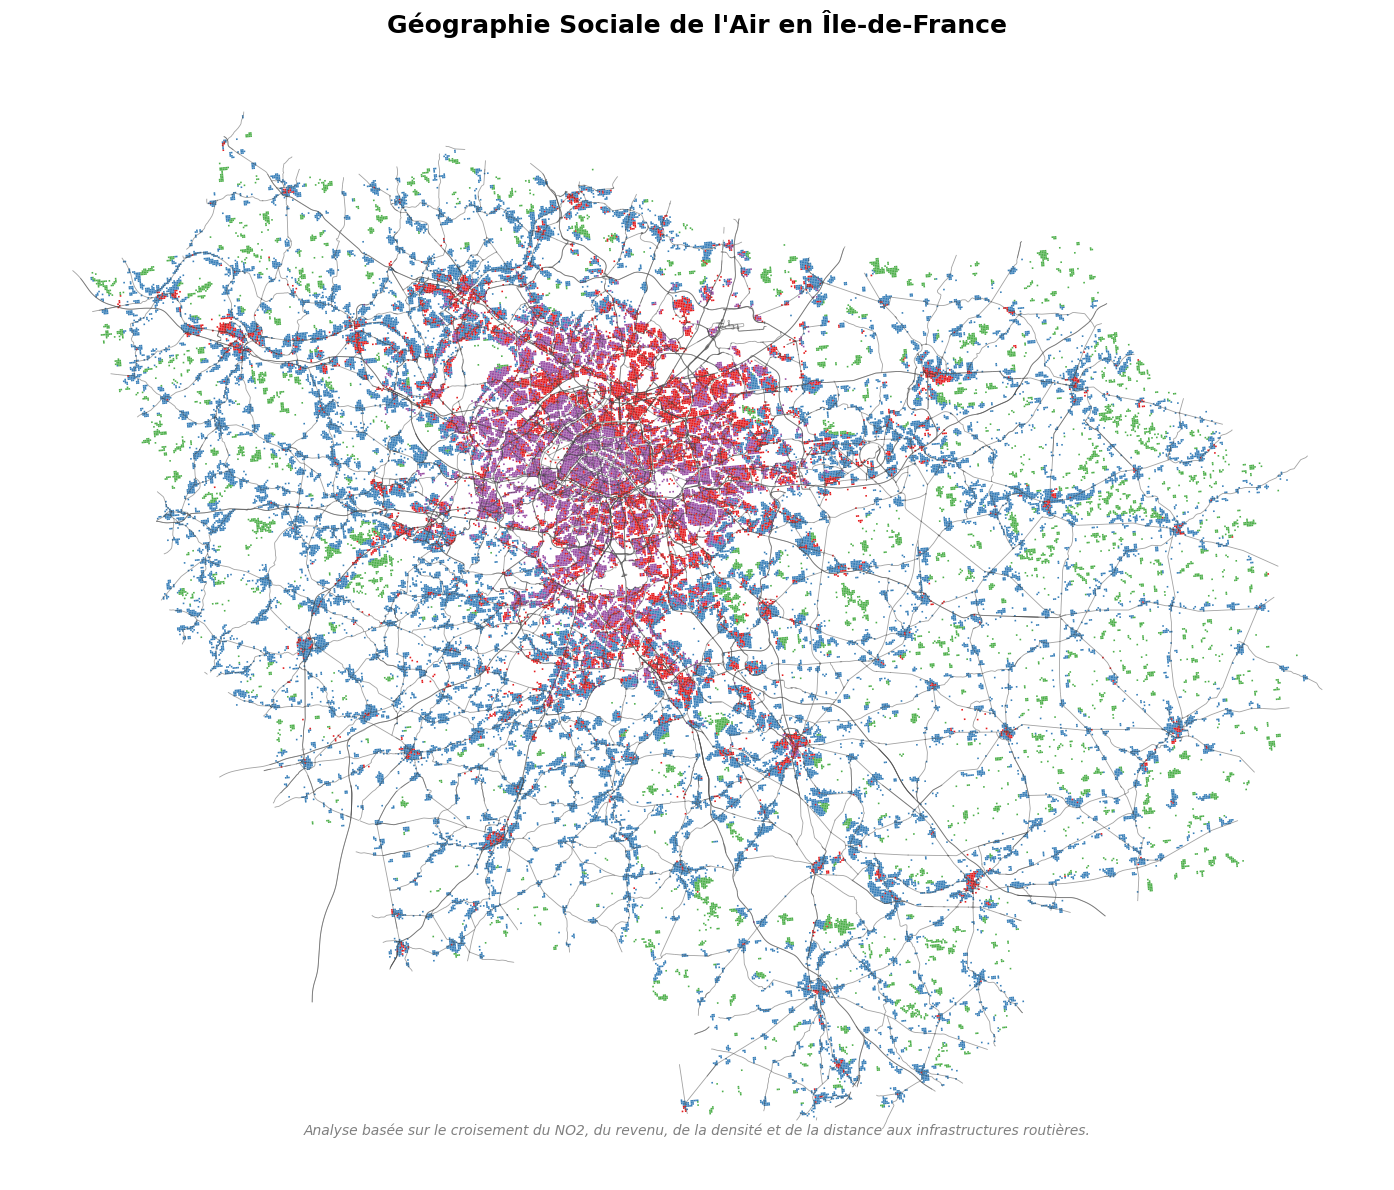

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colors_dict = {
    "Double Peine (Sociale & Air)": "#e41a1c",  
    "L'Élite Polluée": "#984ea3",               
    "Banlieue Pavillonnaire Aisée": "#377eb8",  
    "Le Poumon Vert (Rural)": "#4daf4a"         
}

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

df_ml.plot(column='nom_cluster', 
           color=[colors_dict[val] for val in df_ml['nom_cluster']], 
           ax=ax,
           edgecolor='none')

# Ajout des routes
base_routes.plot(ax=ax, color='#444444', linewidth=0.6, alpha=0.4)

legend_handles = [
    mpatches.Patch(color=color, label=label) 
    for label, color in colors_dict.items()
]

# On ajoute la légende
ax.legend(handles=legend_handles, 
          title="Typologie des Territoires", 
          loc='upper right', 
          fontsize=12, 
          frameon=True)

ax.set_title("Géographie Sociale de l'Air en Île-de-France", fontsize=18, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()